In [1]:
import os 
os.getcwd()

'c:\\Users\\utilisateur\\Documents\\vscode_env\\cas_pratique\\CAS_PRATIQUES\\code'

In [2]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import regularizers
from PIL import Image
from keras.utils import to_categorical
import cv2
import numpy as np

In [3]:
## Prétraitement de l'image : redimensionnemennt et standardization 
def preprocess_img(img,new_dim=(240,320)):
    new_img=cv2.resize(img, (new_dim[1],new_dim[0]), interpolation = cv2.INTER_AREA)
    mean = np.mean(new_img)
    std = np.std(new_img)
    new_img=(new_img-mean)/std
    return new_img

In [4]:
# Chemin vers le dossier principal contenant les sous-dossiers
main_folder = 'C:/Users/utilisateur/Documents/vscode_env/cas_pratique/CAS_PRATIQUES/MMU-Iris-Database'
img_dim=(240,320,3)

In [5]:
X=[]
Y=[]


for target_folder in os.listdir(main_folder):
    target_path = os.path.join(main_folder, target_folder)
    
    if os.path.isdir(target_path):
        for side in ['left']:#, 'right']:
            side_path = os.path.join(target_path, side)
            if os.path.isdir(side_path):
                for image_filename in os.listdir(side_path):
                    if image_filename.lower().endswith(('.bmp', '.jpg', '.png')):
                        image_path = os.path.join(side_path, image_filename)
                        target =int(target_folder)
                        image = preprocess_img(cv2.imread(image_path),img_dim)
                        X.append(image)
                        Y.append(target)

In [12]:
X[0]

array([[[ 1.01144747,  1.01144747,  1.01144747],
        [ 1.01144747,  1.01144747,  1.01144747],
        [ 0.88485627,  1.01144747,  0.88485627],
        ...,
        [-0.63423811, -0.57094251, -0.63423811],
        [-0.76082931, -0.63423811, -0.63423811],
        [-0.63423811, -0.63423811, -0.63423811]],

       [[ 0.88485627,  1.01144747,  0.88485627],
        [ 0.88485627,  1.01144747,  1.01144747],
        [ 0.88485627,  1.01144747,  0.88485627],
        ...,
        [-0.63423811, -0.57094251, -0.63423811],
        [-0.76082931, -0.69753371, -0.76082931],
        [-0.76082931, -0.76082931, -0.63423811]],

       [[ 0.63167387,  0.75826507,  0.75826507],
        [ 0.75826507,  0.82156067,  0.75826507],
        [ 0.88485627,  1.01144747,  0.88485627],
        ...,
        [-0.63423811, -0.57094251, -0.50764692],
        [-0.63423811, -0.63423811, -0.76082931],
        [-0.63423811, -0.63423811, -0.63423811]],

       ...,

       [[ 0.50508267,  0.63167387,  0.63167387],
        [ 0

In [6]:
from sklearn import preprocessing
labelEnc=preprocessing.LabelEncoder()
Y_enc=labelEnc.fit_transform(Y)

In [7]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets while maintaining class distribution
X_train, X_test, y_train, y_test = train_test_split(X, Y_enc, test_size=0.2, random_state=42, stratify=Y_enc)

y_train_enc=to_categorical(y_train)
y_test_enc=to_categorical(y_test)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Create an instance of ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    # width_shift_range=0.2,
    # height_shift_range=0.2,         
    zoom_range=0.2,         
    horizontal_flip=False,   
    fill_mode='constant',
    cval=0

)

augmented_images = []
augmented_labels = []

for img, label in zip(X_train, y_train_enc):   
    x = np.expand_dims(img, axis=0)
    aug_iter = datagen.flow(x, batch_size=1)
    
    num_augmented_samples = 3
    for _ in range(num_augmented_samples):
        augmented_img = next(aug_iter)
        augmented_images.append(augmented_img[0])
        augmented_labels.append(label)

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

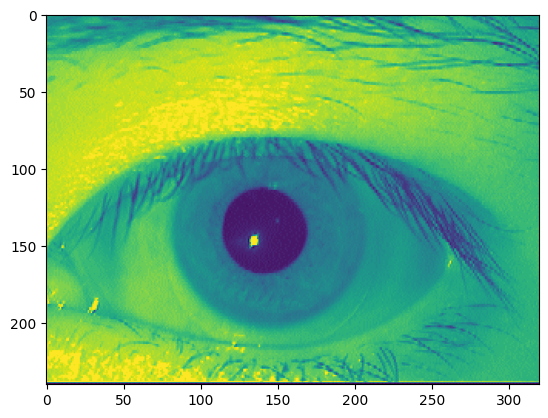

In [14]:
plt.imshow(X_train[5][:,:,2])

In [15]:
from livelossplot import PlotLossesKeras
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
early = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [10]:
from keras.applications.vgg16 import VGG16

from keras.models import Model
from keras.layers import Input, Lambda, Dense, Flatten
NBCLASSES = 45
IMSIZE=[240,320]
def create_model():
    vgg = VGG16(input_shape=IMSIZE + [3], weights='imagenet', include_top=False)
 
    # Freeze existing VGG already trained weights 

    for layer in vgg.layers:
        layer.trainable = False
     
    # get the VGG output
    out = vgg.output
     
    # Add new dense layer at the end
    x = Flatten()(out)
    x = Dense(NBCLASSES, activation='softmax')(x)
     
    model = Model(inputs=vgg.input, outputs=x)
     
    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])
     
    model.summary()
    
    return model
 
OG_model = create_model()

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 6d6bbae143d832006294945121d1f1fc so we will re-download the data.
58889256/58889256 [==============================] - 924s 16us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 320, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 320, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 160, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 160, 128)     73856 

In [16]:
import numpy as np 

X_train = np.concatenate((X_train, augmented_images), axis=0)
y_train = np.concatenate((y_train_enc, augmented_labels), axis=0)

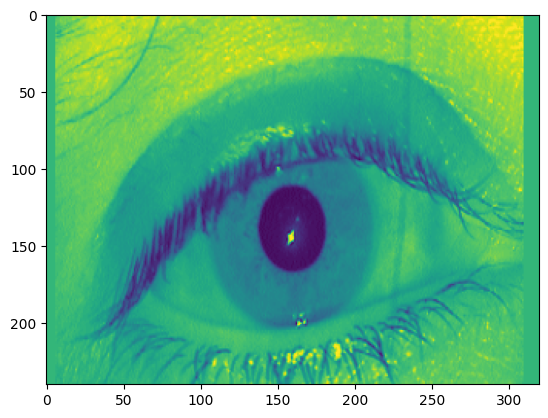

In [18]:
plt.imshow(X_train[456][:,:,2])

In [19]:
len(y_train)

720

In [20]:
from livelossplot import PlotLossesKeras
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
early = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [21]:
hist = OG_model.fit(np.array(X_train), np.array(y_train), batch_size = 10, epochs = 100, validation_split=0.25,callbacks=[rlrop,early,PlotLossesKeras()])

Epoch 1/100
54/54 [==============================] - ETA: 0s - loss: 2.8500 - accuracy: 0.6407

KeyboardInterrupt: 